In [41]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, BatchNormalization, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [59]:
df = pd.read_csv("modified_QUANTT_dataset.csv")

In [60]:
# df = df[df["Average Value"] < 20]

In [61]:
data = df[['Stock price','Strike price','T','Risk-Free Rate','Implied Volatility']]
targets = df['Average Value']

In [62]:
X_train, X_test, y_train, y_test  = train_test_split(data, targets, test_size=0.2, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, shuffle=True)

In [63]:
print(X_train.shape, X_test.shape, X_val.shape)

(20616, 5) (2577, 5) (2577, 5)


Epoch 1/10000
323/323 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - MAE: 20.3253 - loss: 1540.8948 - val_MAE: 17.6022 - val_loss: 1318.1340
Epoch 2/10000
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - MAE: 18.8454 - loss: 1433.2595 - val_MAE: 16.4618 - val_loss: 1221.6069
Epoch 3/10000
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - MAE: 18.0393 - loss: 1380.4138 - val_MAE: 15.2355 - val_loss: 1067.4231
Epoch 4/10000
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - MAE: 16.4120 - loss: 1146.9521 - val_MAE: 14.2212 - val_loss: 873.0052
Epoch 5/10000
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - MAE: 15.3233 - loss: 909.4589 - val_MAE: 13.6351 - val_loss: 681.0530
Epoch 6/10000
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - MAE: 14.7439 - loss: 736.1569 - val_MAE: 13.4913 - val_loss: 576.8007
Epoch 7/10000
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - MAE: 14.3098 - loss: 640.4628 - val_MAE: 13.1203 - val_loss: 540.4563
Epoch 8/10000
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - MAE: 14.0543 - loss: 606.2888 - val_MAE: 12.709

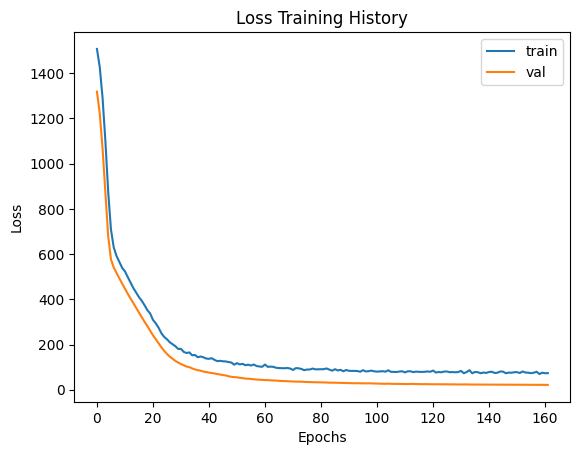

In [69]:
input1 = Input(shape=(X_train.shape[1],), name='input')
normalized_input = BatchNormalization()(input1)

ann_layer1 = Dense(32, activation='relu')(normalized_input)
dropout = Dropout(0.1)(ann_layer1)  
ann_layer2 = Dense(32, activation='relu')(dropout)
dropout2 = Dropout(0.1)(ann_layer2)  

output_layer = Dense(1, activation='relu')(dropout2)

model = tf.keras.Model(inputs=input1, outputs=output_layer)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, clipvalue=1.0)
model.compile(optimizer=optimizer, loss="MSE", metrics=["MAE"])

early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True, min_delta=0.01, start_from_epoch=100)

history = model.fit(X_train, y_train, epochs=10000, batch_size=64, verbose=1, validation_data=(X_val, y_val), callbacks=[early_stopping], shuffle=True)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


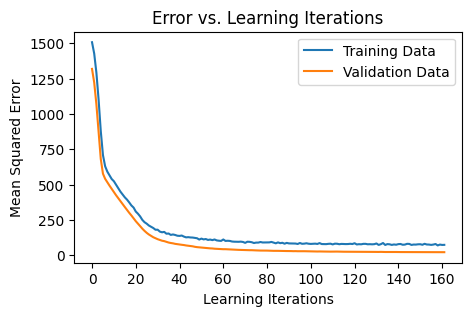

In [74]:

plt.figure(figsize=(5, 3))
plt.plot(history.history['loss'], label='Training Data')
plt.plot(history.history['val_loss'], label='Validation Data')
plt.title('Error vs. Learning Iterations')
plt.xlabel('Learning Iterations')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


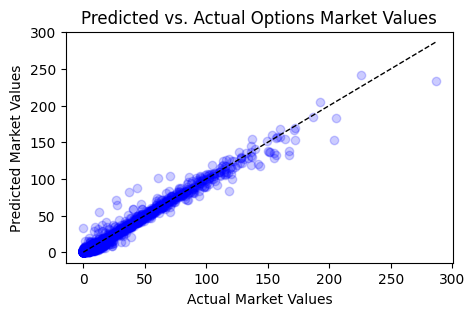

In [72]:
import matplotlib.pyplot as plt

# Generate predictions for the test set
y_pred = model.predict(X_test)

# Visualizing the predictions against the actual Black-Scholes values
plt.figure(figsize=(5, 3))
plt.scatter(y_test, y_pred, c='b', alpha=0.2)
plt.title('Predicted vs. Actual Options Market Values')
plt.xlabel('Actual Market Values')
plt.ylabel('Predicted Market Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)  # Diagonal line for reference
plt.show()


In [121]:
y_pred_flat = y_pred.flatten()

X_test_df = X_test.copy()

# Add y_test and y_pred_flat to the DataFrame
X_test_df['y_test'] = y_test  # Reset index to ensure alignment
X_test_df['y_pred'] = y_pred_flat  # Convert y_pred_flat to a Series for alignment


In [ ]:
X_test_df.sort_values(by='y_test').sort_values(by='y_pred')

In [67]:
model.save('neural_network_model.keras')
model.save_weights('neural_network_model.weights.h5')